In [1]:
pip install torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-1

In [2]:
pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.1.0+cpu.html

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.7 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.4/500.4 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.1/753.1 kB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.3/210.3 kB 15.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.1 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [17]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data as GraphData

In [28]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Hyperparameters
batch_size = 32
num_epochs = 30
learning_rate = 0.001


Using device: cuda


In [29]:
# Transform
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

In [30]:
# Dataset paths
train_path = "/kaggle/input/anc-tamil/archive (1)/train"
val_path = "/kaggle/input/anc-tamil/archive (1)/test"

# Load datasets
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
val_dataset = datasets.ImageFolder(root=val_path, transform=transform)
num_classes = len(train_dataset.classes)  # dynamically detect class count

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [31]:
# Model Definition
class HybridModel(nn.Module):
    def __init__(self, num_classes):
        super(HybridModel, self).__init__()

        # CNN
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> [16, 16, 16]
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> [32, 8, 8]
        )

        self.feature_h, self.feature_w = 8, 8
        self.rnn_input_size = 32
        self.rnn_seq_len = self.feature_h * self.feature_w  # 64
        self.rnn = nn.GRU(input_size=self.rnn_input_size, hidden_size=64, batch_first=True)

        self.gnn = GCNConv(64, 64)

        # Fully connected layer
        self.fc = nn.Linear(self.rnn_seq_len * 64, num_classes)

        # Precompute edge_index
        edge_index = torch.combinations(torch.arange(self.rnn_seq_len), r=2).t()
        self.edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1).to(device)

    def forward(self, x):
        batch_size = x.size(0)
        x = self.cnn(x)  # [B, 32, 8, 8]
        x = x.permute(0, 2, 3, 1).contiguous()  # [B, 8, 8, 32]
        x = x.view(batch_size, self.rnn_seq_len, self.rnn_input_size)  # [B, 64, 32]

        rnn_out, _ = self.rnn(x)  # [B, 64, 64]
        rnn_out = rnn_out.to(device)

        out_list = []
        for i in range(batch_size):
            node_features = rnn_out[i]  # [64, 64]
            graph = GraphData(x=node_features, edge_index=self.edge_index)
            gnn_out = self.gnn(graph.x, graph.edge_index)  # [64, 64]
            out_list.append(gnn_out.view(-1))  # [64 * 64]

        out = torch.stack(out_list).to(device)  # [B, 4096]
        out = self.fc(out)
        return out


In [32]:
# Instantiate model
model = HybridModel(num_classes=num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Tracking
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Training loop
for epoch in range(num_epochs):
    model.train()
    correct, total, running_loss = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    correct, total, val_loss = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} => "
          f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

Epoch 1/30 => Train Acc: 22.90%, Val Acc: 31.63%
Epoch 2/30 => Train Acc: 25.79%, Val Acc: 40.82%
Epoch 3/30 => Train Acc: 37.76%, Val Acc: 44.90%
Epoch 4/30 => Train Acc: 41.31%, Val Acc: 54.08%
Epoch 5/30 => Train Acc: 52.62%, Val Acc: 44.90%
Epoch 6/30 => Train Acc: 53.36%, Val Acc: 47.96%
Epoch 7/30 => Train Acc: 53.08%, Val Acc: 37.76%
Epoch 8/30 => Train Acc: 56.17%, Val Acc: 38.78%
Epoch 9/30 => Train Acc: 63.18%, Val Acc: 62.24%
Epoch 10/30 => Train Acc: 62.62%, Val Acc: 61.22%
Epoch 11/30 => Train Acc: 68.60%, Val Acc: 65.31%
Epoch 12/30 => Train Acc: 75.98%, Val Acc: 67.35%
Epoch 13/30 => Train Acc: 79.72%, Val Acc: 62.24%
Epoch 14/30 => Train Acc: 81.59%, Val Acc: 82.65%
Epoch 15/30 => Train Acc: 81.21%, Val Acc: 76.53%
Epoch 16/30 => Train Acc: 82.90%, Val Acc: 75.51%
Epoch 17/30 => Train Acc: 81.87%, Val Acc: 85.71%
Epoch 18/30 => Train Acc: 84.30%, Val Acc: 78.57%
Epoch 19/30 => Train Acc: 85.51%, Val Acc: 84.69%
Epoch 20/30 => Train Acc: 87.20%, Val Acc: 86.73%
Epoch 21/

In [34]:
torch.save(model.state_dict(), 'tamil_cnn_rnn_gnn.pth')

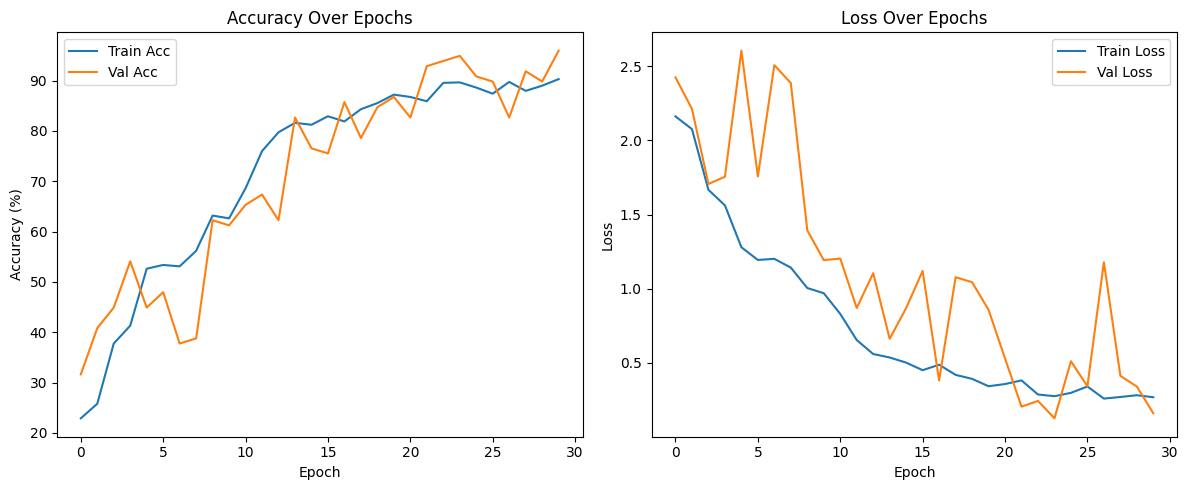

In [35]:
# Accuracy and loss graph
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()
